In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dropout
from keras.layers import Dense
from keras.regularizers import l2
from keras.regularizers import l1
from keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Run vs Pass classification NFL
def build():
    network = keras.models.Sequential()
    network.add(Dense(182, activation = 'elu', input_shape=(x_train.shape[1],), kernel_regularizer=l1(1.e-4)))
    network.add(Dense(52, activation = 'relu', kernel_regularizer=l2(1.e-3)))
    network.add(Dense(1, activation = 'sigmoid'))
    network.compile(loss='binary_crossentropy', optimizer="adamax" ,metrics=['accuracy'])
    return network



#Data preparation for classification NFL
def data_prep(data):
    data.drop(columns=['yards_gained'], inplace=True)
    y = data['play_type']
    x = data.drop(columns = ['play_type'])
    x = pd.get_dummies(x)
    y = y.apply(playtypetobinary)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    cols = ['yardline_100', 'quarter_seconds_remaining', 'ydstogo', 'score_differential']
    for x in cols:
        mean = x_train[x].mean(axis=0)
        x_train[x] -= mean
        std = x_train[x].std(axis=0)
        x_train[x] /= std
        x_test[x] -= mean
        x_test[x] /= std
    return x_train, x_test, y_train, y_test

#Classification k-cross-validation
def cross_valid_reg(k, num_epochs, x_train, y_train, x_test, y_test):
    samples = len(x_train) // k
    val_history = []
    train_history = []
    for i in range(k):
        data = x_train[i * samples: (i + 1) * samples]
        targets = y_train[i * samples: (i + 1) * samples]
        partial_train_data = np.concatenate([x_train[:i * samples], x_train[(i + 1) * samples:]],axis=0)
        partial_train_targets = np.concatenate([y_train[:i * samples],y_train[(i + 1) * samples:]],axis=0)
        model = build()
        if i == 0:
            print('Input size: ', x_train.shape)
            print(model.summary())
        hist = model.fit(partial_train_data, partial_train_targets, validation_data=(data, targets),
                         epochs=num_epochs, batch_size=100, verbose=0)
        loss_history1 = hist.history['val_loss']
        loss_history2 = hist.history['loss']
        val_history.append(loss_history1)
        train_history.append(loss_history2)
        
    val_history = [np.mean([x[i] for x in val_history]) for i in range(num_epochs)]
    train_history = [np.mean([x[i] for x in train_history]) for i in range(num_epochs)]
    plt.figure(figsize=(12, 8))
    plt.rcParams.update({'font.size': 24})
    plt.plot(range(1, len(val_history) + 1), val_history)
    plt.plot(range(1, len(train_history) + 1), train_history)
    plt.xlabel('Epochs')
    plt.ylabel('loss_function')
    plt.legend(['Validation', 'Training'])
    plt.savefig('PassNFL.png')
    plt.show()
    _,mae = model.evaluate(x_test, y_test)
    print('Accuracy of the network is ', mae)
    with open('PassNFL.txt', 'w') as outfile:
        for x in range(len(val_history)):
            print(x, ' ', val_history[x], ' ', train_history[x], file=outfile)
    
    return model    
    
def playtypetobinary(x):
    if x=='run':
        x = 0
    else:
        x = 1
    return x

Input size:  (258336, 93)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 182)               17108     
_________________________________________________________________
dense_1 (Dense)              (None, 52)                9516      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 53        
Total params: 26,677
Trainable params: 26,677
Non-trainable params: 0
_________________________________________________________________
None


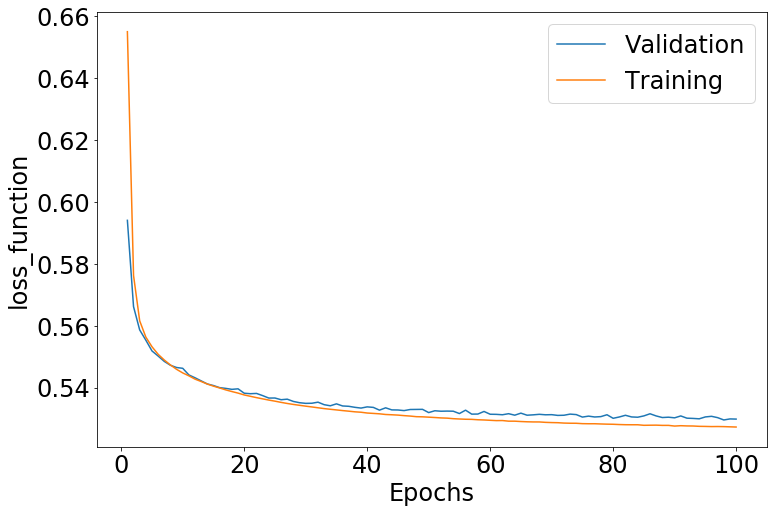

2019/2019 [==============================] - 2s 974us/step - loss: 0.5322 - accuracy: 0.7341
Accuracy of the network is  0.7341178059577942
Guessing that every play is a pass generates accuracy:  0.5787037037037037


In [3]:
#NFL run vs pass classification
data = pd.read_csv("data/readyToGoNFL.csv")
x_train, x_test, y_train, y_test = data_prep(data)

#Benchmark
benchmark = y_train.value_counts(normalize = True)

model = cross_valid_reg(4, 100, x_train, y_train, x_test, y_test)
print('Guessing that every play is a pass generates accuracy: ', benchmark[1])

C:\Users\filip\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


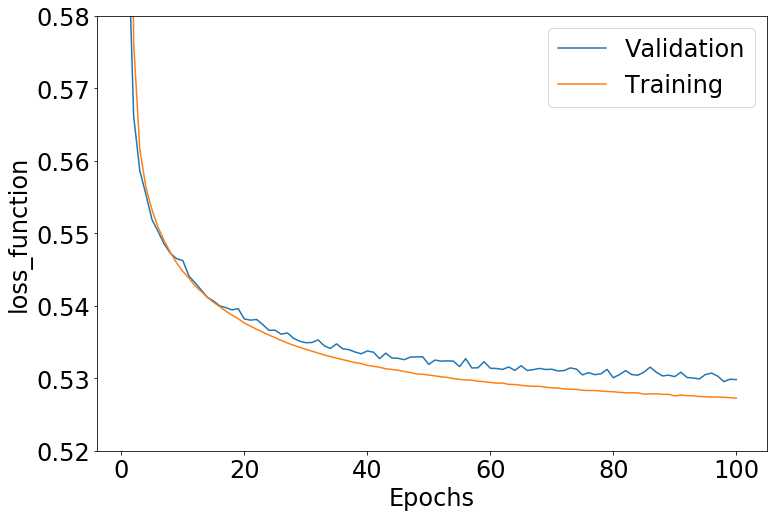

In [10]:
plot = pd.read_csv('historyClassNFL.txt', header = None, sep = '  ', names = ['Epochs', 'Validation', 'Training'])
plot = plot.set_index(['Epochs'])

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 24})
plt.plot(range(1, len(plot['Validation']) + 1), plot['Validation'])
plt.plot(range(1, len(plot['Training']) + 1), plot['Training'])
plt.xlabel('Epochs')
plt.ylabel('loss_function')
plt.legend(['Validation', 'Training'])
plt.ylim([0.52,0.58])
plt.savefig('PassNFL1.png')
plt.show()

313/313 [==============================] - 0s 1ms/step - loss: 0.5258 - accuracy: 0.7354


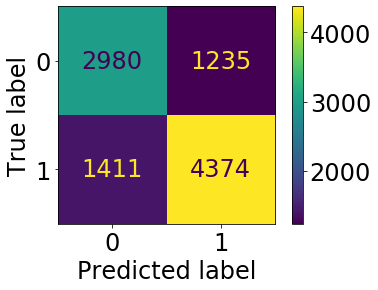

In [13]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test[:10000], model.predict_classes(x_test[:10000]).tolist()))
model.evaluate(x_test[:10000], y_test[:10000])
disp.plot()
plt.savefig('PassNFLConf1.png')